In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomRotation(85),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [4]:
train_path = "/content/drive/MyDrive/AA_MEB/v3_Binary_keratosisVSmel_dataset/train/"
val_path = "/content/drive/MyDrive/AA_MEB/v3_Binary_keratosisVSmel_dataset/val/"
test_path = "/content/drive/MyDrive/AA_MEB/v3_Binary_keratosisVSmel_dataset/test/"

train_dataset = torchvision.datasets.ImageFolder(train_path, transform = transform)
val_dataset = torchvision.datasets.ImageFolder(val_path, transform = transform)
test_dataset = torchvision.datasets.ImageFolder(test_path, transform = transform)

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)

In [6]:
print("training set contains:", len(train_dataset), "images")
print("validation set contains:", len(val_dataset), "images")
print("testing set contains:", len(test_dataset), "images")

training set contains: 502 images
validation set contains: 62 images
testing set contains: 64 images


In [7]:
print(train_dataset.class_to_idx)

{'keratosis': 0, 'melanoma': 1}


In [8]:
images, labels = next(iter(train_loader))

images.shape # [batch_size, color_channels, height, width]

torch.Size([16, 3, 200, 200])

In [9]:
print("Number of images in training set: {}".format(len(train_dataset)))
print("Number of images in test set: {}".format(len(val_dataset)))
print("Number of images in test set: {}".format(len(test_dataset)))

print("...")

print("Number of batches in the train loader: {}".format(len(train_loader)))
print("Number of batches in the test loader: {}".format(len(val_loader)))
print("Number of batches in the test loader: {}".format(len(test_loader)))

Number of images in training set: 502
Number of images in test set: 62
Number of images in test set: 64
...
Number of batches in the train loader: 32
Number of batches in the test loader: 4
Number of batches in the test loader: 4


In [10]:
CUDA = torch.cuda.is_available()

if CUDA:
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


In [11]:
from torchvision import models

In [12]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
  param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)

model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
def accuracy(predictions, labels):
    classes = torch.argmax(predictions, dim=1)
    return torch.mean((classes == labels).float())

In [14]:
import numpy as np

epochs = 50
min_valid_loss = np.inf

train_loss_values = []
valid_loss_values = []
train_acc = []
val_acc = []

for e in range(epochs):
    train_loss = []
    running_train_accuracy = 0.00

    model.train()     # Optional when not using Model Specific layer
    size = len(train_loader.dataset)
    for data, labels in train_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
            batch, c, h, w = data.shape 
        
        optimizer.zero_grad()
        predictions = model(data)
        t_loss = criterion(predictions,labels)
        t_loss.backward()
        optimizer.step()
        train_loss.append(t_loss.item())

        running_train_accuracy += accuracy(predictions, labels)

    running_train_accuracy /= len(train_loader)
    train_acc.append(running_train_accuracy.cpu())

    train_loss_values.append(np.array(train_loss).mean())

    valid_loss = []
    
    model.eval()     # Optional when not using Model Specific layer
    running_val_accuracy = 0.00
    for data, labels in val_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        predictions = model(data)
        v_loss = criterion(predictions,labels)
        valid_loss.append(v_loss.item())
        running_val_accuracy += accuracy(predictions, labels)

    running_val_accuracy /= len(val_loader)

    valid_loss_values.append(np.array(valid_loss).mean())
    val_acc.append(running_val_accuracy.cpu())

    print(f'Epoch {e+1} \t\t Training Loss: {t_loss.item()} \t\t Validation Loss: {v_loss.item()}')
    print(f'Metrics \t\t Training accuracy: {running_train_accuracy} \t\t Validation accuracy: {running_val_accuracy}') 
        
        
    # Saving State Dict
    torch.save(model.state_dict(), '/content/drive/MyDrive/AA_MEB/v3_resnet50_model.pth')

Epoch 1 		 Training Loss: 0.6143007278442383 		 Validation Loss: 0.5558739304542542
Metrics 		 Training accuracy: 0.5963541865348816 		 Validation accuracy: 0.6830357313156128
Epoch 2 		 Training Loss: 0.7062558531761169 		 Validation Loss: 0.6344978213310242
Metrics 		 Training accuracy: 0.6790364384651184 		 Validation accuracy: 0.6116071343421936
Epoch 3 		 Training Loss: 0.591852605342865 		 Validation Loss: 0.4760798513889313
Metrics 		 Training accuracy: 0.7102864384651184 		 Validation accuracy: 0.7142857313156128
Epoch 4 		 Training Loss: 0.632834255695343 		 Validation Loss: 0.6422214508056641
Metrics 		 Training accuracy: 0.7115885615348816 		 Validation accuracy: 0.7254464626312256
Epoch 5 		 Training Loss: 0.5205462574958801 		 Validation Loss: 0.5184890031814575
Metrics 		 Training accuracy: 0.7330729365348816 		 Validation accuracy: 0.7299107313156128
Epoch 6 		 Training Loss: 0.5242193341255188 		 Validation Loss: 0.5003589987754822
Metrics 		 Training accuracy: 0.749348

Text(0, 0.5, 'loss')

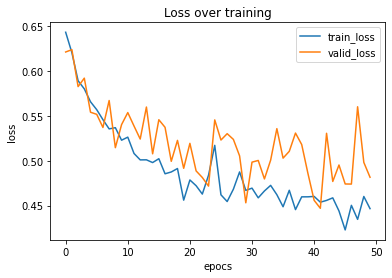

In [15]:
plt.title("Loss over training")
plt.plot(train_loss_values)
plt.plot(valid_loss_values)
plt.legend(["train_loss", "valid_loss"])
plt.xlabel("epocs")
plt.ylabel("loss")

Text(0, 0.5, 'accuracy')

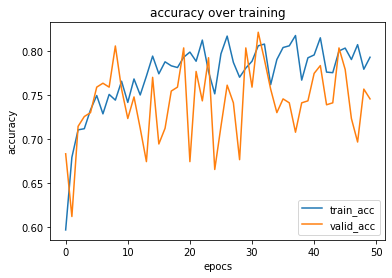

In [16]:
plt.title("accuracy over training")
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(["train_acc", "valid_acc"])
plt.xlabel("epocs")
plt.ylabel("accuracy")

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import recall_score, accuracy_score, classification_report

In [18]:
y_pred = []
y_pred_prob = []
y_true = []

model = model.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/AA_MEB/v3_resnet50_model.pth'))
model.eval()

# iterate over test data
for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs) # Feed Network

        output_pred = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output_pred)
        output_prob = torch.softmax(output.cpu(), dim=1)[:, 1].data.cpu().numpy()
        y_pred_prob.extend(output_prob) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        #labels = labels.cpu()
        y_true.extend(labels) # Save Truth

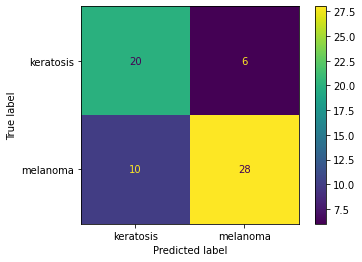

In [19]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.class_to_idx)
disp.plot()

In [20]:
cr = classification_report(y_true, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.67      0.77      0.71        26
           1       0.82      0.74      0.78        38

    accuracy                           0.75        64
   macro avg       0.75      0.75      0.75        64
weighted avg       0.76      0.75      0.75        64

